In [1]:
cd ..

/home/vtenorio/Codigo/robust_gnn/inference_langevin


In [2]:
import numpy as np
from robust_gnn_demo import data
from robust_gnn_demo.model import RobustGNNScore, GFGCN

import torch
import torch.nn as nn

torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)

import numpy as np
import torch
import networkx as nx
import pickle as pkl
import matplotlib.pyplot as plt 

from langevin.utils import load_model, score_edp_wrapper

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert torch.cuda.is_available()

In [4]:
def test(model, x, y, train_idx, val_idx, test_idx, lr, wd, n_epochs, es_patience=-1, eval_freq=4, verbose=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = nn.MSELoss()

    loss_train, loss_val, loss_test = [np.zeros(n_epochs) for _ in range(3)]

    best_val_loss = np.inf
    best_test_loss = 0
    es_count = 0

    for i in range(n_epochs):
        yhat = model(x)
        loss = loss_fn(yhat[train_idx,:,:], y[train_idx,:,:])

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_train[i] = loss.item()
        loss_val[i] = ((yhat[val_idx,:,:] - y[val_idx,:,:])**2).mean().item()
        loss_test[i] = ((yhat[test_idx,:,:] - y[test_idx,:,:])**2).mean().item()

        if loss_val[i] < best_val_loss:
            es_count = 0
            best_val_loss = loss_val[i]
            best_test_loss = loss_test[i]
        else:
            es_count += 1

        if es_patience > 0 and es_count > es_patience:
            break

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Train Loss: {loss_train[i]} - Val Loss: {loss_val[i]} - Test Loss: {loss_test[i]}", flush=True)

    return loss_train, loss_val, loss_test, best_val_loss, best_test_loss

# Data

In [5]:
pert_type = "rewire"
eps = 0.15

n_iters_H = 50
n_epochs = 500
lr = 0.001
wd = 1e-2
eval_freq = 1
es_patience = 100
lr_S = 1e-3

n_iters = 100
n_iters_S = 1#15

hid_dim = 16
n_layers = 2
bias = True
dropout = 0.25
K = 3
norm_S = True
act = nn.Tanh
batch_norm = False

in_dim = 1
out_dim = 1

model_params = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'act': act,
    'bias': bias,
    'dropout': dropout,
    'K': K,
    'norm_S': norm_S,
    'batch_norm': batch_norm
}

In [6]:
# Maximum number of nodes in the dataset used to train the score network
max_nodes = 25
# Sigmas used to train the network
sigmas = np.linspace(0.5, 0.03, 10)

model_file = ("robust_gnn_demo/egonets_score_network.pth")
with open("robust_gnn_demo/egonets_dataset_test.pkl", "rb") as f:
    graphs = [g for g in pkl.load(f)]

# Select a random adjacency matrix from the dataset
g = graphs[15]

model = load_model(model_file)
prior_score_estimator = score_edp_wrapper(model, g.number_of_nodes(), len(sigmas), max_nodes)

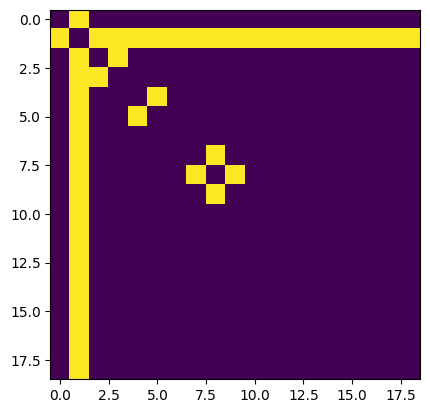

In [7]:
plt.imshow(nx.to_numpy_array(g))

In [8]:
N = 20
p_er = 0.2
g_params = {'type': data.GIVEN, 'g': g}
norm_S = False
norm_H = False
sort_h = False
neg_coefs = False
exp_coefs = True
pert_type = "noise"

M = 100
p_n = 0.05
eps = 0.1
K = 3

gamma = 0
beta = 0.1
lambd = 1.
omega = 0.1

sigmas = np.linspace(0.5, 0.03, 10)
sigma_i_idx = sigmas.shape[0]-1
sigma = sigmas[sigma_i_idx]
sigmas, sigma_i_idx, sigma

(array([0.5       , 0.44777778, 0.39555556, 0.34333333, 0.29111111,
        0.23888889, 0.18666667, 0.13444444, 0.08222222, 0.03      ]),
 9,
 0.03)

In [9]:
X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

In [10]:
X = torch.tensor(X).to(device).T[:,:,None].double()
Y = torch.tensor(Y).to(device).T[:,:,None].double()
S = torch.tensor(S).to(device).double()
Sn = torch.tensor(Sn).to(device).double()

In [11]:
idxs_y_split = torch.randperm(M)
N_train = 0.7
N_val = 0.15
train_idx = idxs_y_split[:int(N_train*M)]
val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
test_idx = idxs_y_split[int((N_train+N_val)*M):]

In [12]:
# model = RobustGNNScore(Sn, n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigma_i_idx=sigma_i_idx)
# model.model = model.model.double().to(device)

# results_dict, S_dict = model.test_model(Sn, X, Y, gamma, lambd, beta, omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=True, debug_S=False)

# Exhaustive tests

## Pert rewire

In [13]:
pert_type = "rewire"
eps = 0.15

In [14]:
n_graphs = 15

loss_test_score = np.zeros(n_graphs)
loss_test_sparsity = np.zeros(n_graphs)
loss_test_sparsity_score = np.zeros(n_graphs)
loss_test_pert = np.zeros(n_graphs)

for g in range(n_graphs):
    print(f"{g+1} ", end="", flush=True)

    idx_g = np.random.randint(len(graphs))
    g_params['g'] = graphs[idx_g]

    X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

    X = torch.tensor(X).to(device).T[:,:,None].double()
    Y = torch.tensor(Y).to(device).T[:,:,None].double()
    S = torch.tensor(S).to(device).double()
    Sn = torch.tensor(Sn).to(device).double()

    idxs_y_split = torch.randperm(M)
    N_train = 0.7
    N_val = 0.15
    train_idx = idxs_y_split[:int(N_train*M)]
    val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
    test_idx = idxs_y_split[int((N_train+N_val)*M):]

    # Ignoring perturbations
    model = GFGCN(Sn.clone(), in_dim, hid_dim, out_dim, n_layers, K, bias=bias, act=act, grad_S=False).double().to(device)

    loss_train, loss_val, loss_test, best_val_loss, loss_test_pert[g] = test(model, X, Y, train_idx, val_idx, test_idx, lr, wd, n_epochs, eval_freq=50, verbose=False)

    # With score function
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=sigma_i_idx)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=0., omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_score[g] = results_dict['best_acc_test'].item()

    # With sparsity term
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=sigma_i_idx)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=beta, omega=0., train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_sparsity[g] = results_dict['best_acc_test'].item()

    # Both sparsity and score
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=sigma_i_idx)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=beta, omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_sparsity_score[g] = results_dict['best_acc_test'].item()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

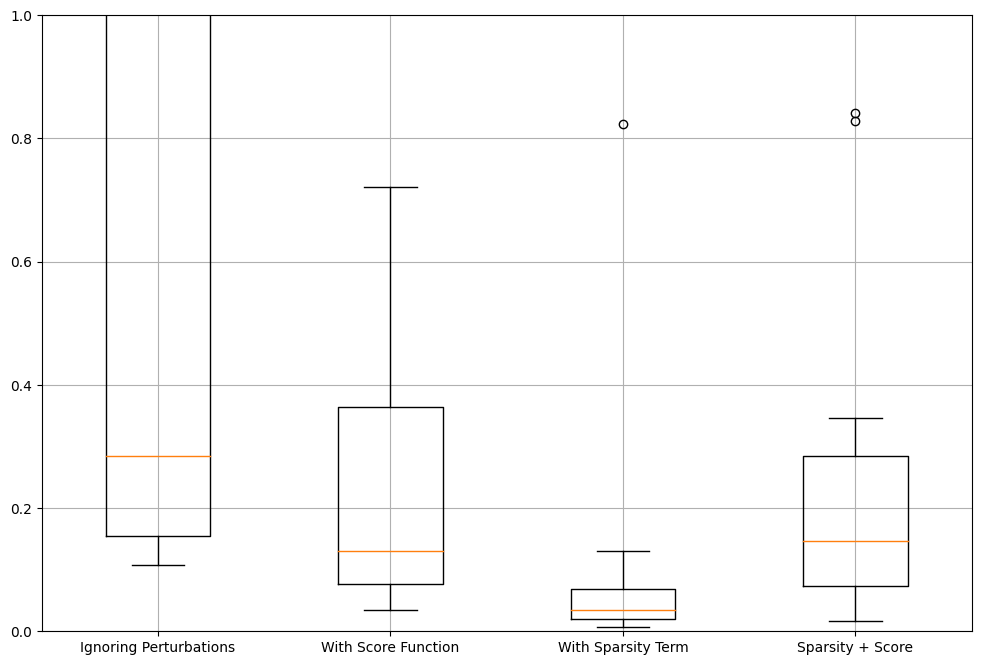

In [15]:
plt.figure(figsize=(12,8))
plt.boxplot([loss_test_pert, loss_test_score, loss_test_sparsity, loss_test_sparsity_score])
plt.xticks(np.arange(1,5), ["Ignoring Perturbations", "With Score Function", "With Sparsity Term", "Sparsity + Score"])
plt.ylim([0,1])
plt.grid()

## Pert Noise

In [16]:
pert_type = "noise"
eps = 0.1

In [17]:
n_graphs = 15

loss_test_score = np.zeros(n_graphs)
loss_test_sparsity = np.zeros(n_graphs)
loss_test_pert = np.zeros(n_graphs)

for g in range(n_graphs):
    print(f"{g+1} ", end="")

    idx_g = np.random.randint(len(graphs))
    g_params['g'] = graphs[idx_g]

    X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

    X = torch.tensor(X).to(device).T[:,:,None].double()
    Y = torch.tensor(Y).to(device).T[:,:,None].double()
    S = torch.tensor(S).to(device).double()
    Sn = torch.tensor(Sn).to(device).double()

    idxs_y_split = torch.randperm(M)
    N_train = 0.7
    N_val = 0.15
    train_idx = idxs_y_split[:int(N_train*M)]
    val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
    test_idx = idxs_y_split[int((N_train+N_val)*M):]

    # Ignoring perturbations
    model = GFGCN(Sn.clone(), in_dim, hid_dim, out_dim, n_layers, K, bias=bias, act=act).double().to(device)

    loss_train, loss_val, loss_test, best_val_loss, loss_test_pert[g] = test(model, X, Y, train_idx, val_idx, test_idx, lr, wd, n_epochs, eval_freq=50, verbose=False)

    # With score function
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=sigma_i_idx)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=0., alpha=0.1, omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_score[g] = results_dict['best_acc_test'].item()

    # With sparsity term
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=sigma_i_idx)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=beta, alpha=0.1, omega=0., train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_sparsity[g] = results_dict['best_acc_test'].item()

1 

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

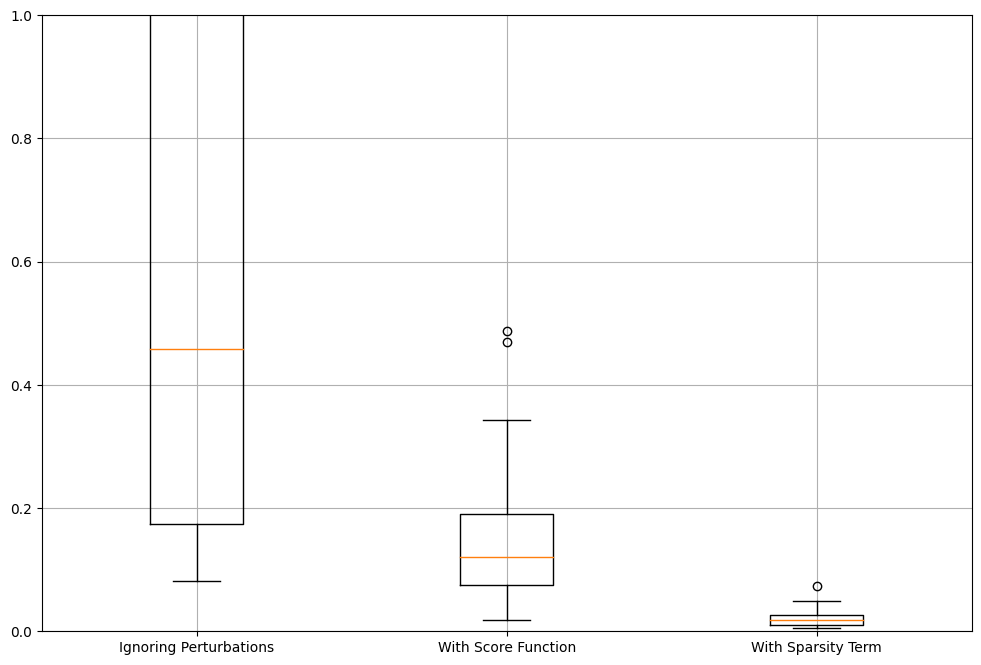

In [18]:
plt.figure(figsize=(12,8))
plt.boxplot([loss_test_pert, loss_test_score, loss_test_sparsity])
plt.xticks(np.arange(1,4), ["Ignoring Perturbations", "With Score Function", "With Sparsity Term"])
plt.ylim([0,1])
plt.grid()

# Trying out different sigma values

In [19]:
pert_type = "rewire"
eps = 0.15

In [20]:
n_graphs = 10

loss_test_score = np.zeros((sigmas.shape[0], n_graphs))

for sigma_idx, sigma in enumerate(sigmas):

    print(f"Starting with sigma value {sigma} - {sigma_idx+1} / {len(sigmas)}")
    
    for g in range(n_graphs):
        print(f"{g+1} ", end="", flush=True)

        idx_g = np.random.randint(len(graphs))
        g_params['g'] = graphs[idx_g]

        X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

        X = torch.tensor(X).to(device).T[:,:,None].double()
        Y = torch.tensor(Y).to(device).T[:,:,None].double()
        S = torch.tensor(S).to(device).double()
        Sn = torch.tensor(Sn).to(device).double()

        idxs_y_split = torch.randperm(M)
        N_train = 0.7
        N_val = 0.15
        train_idx = idxs_y_split[:int(N_train*M)]
        val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
        test_idx = idxs_y_split[int((N_train+N_val)*M):]

        # With score function
        model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=sigma_idx, dec_sigma=False)
        model.model = model.model.double().to(device)

        results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=0., omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
        loss_test_score[sigma_idx,g] = results_dict['best_acc_test'].item()
    print("- DONE")

Starting with sigma value 0.5 - 1 / 10
1 

2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.4477777777777778 - 2 / 10
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.39555555555555555 - 3 / 10
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.3433333333333334 - 4 / 10
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.2911111111111111 - 5 / 10
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.23888888888888893 - 6 / 10
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.1866666666666667 - 7 / 10
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.13444444444444448 - 8 / 10
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.08222222222222225 - 9 / 10
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.03 - 10 / 10
1 2 3 4 5 6 7 8 9 10 - DONE


In [21]:
best_sigma_idx = np.argmin(np.mean(loss_test_score, 1))
print(f"Best sigma: {sigmas[best_sigma_idx]} - with idx: {best_sigma_idx}")

Best sigma: 0.5 - with idx: 0


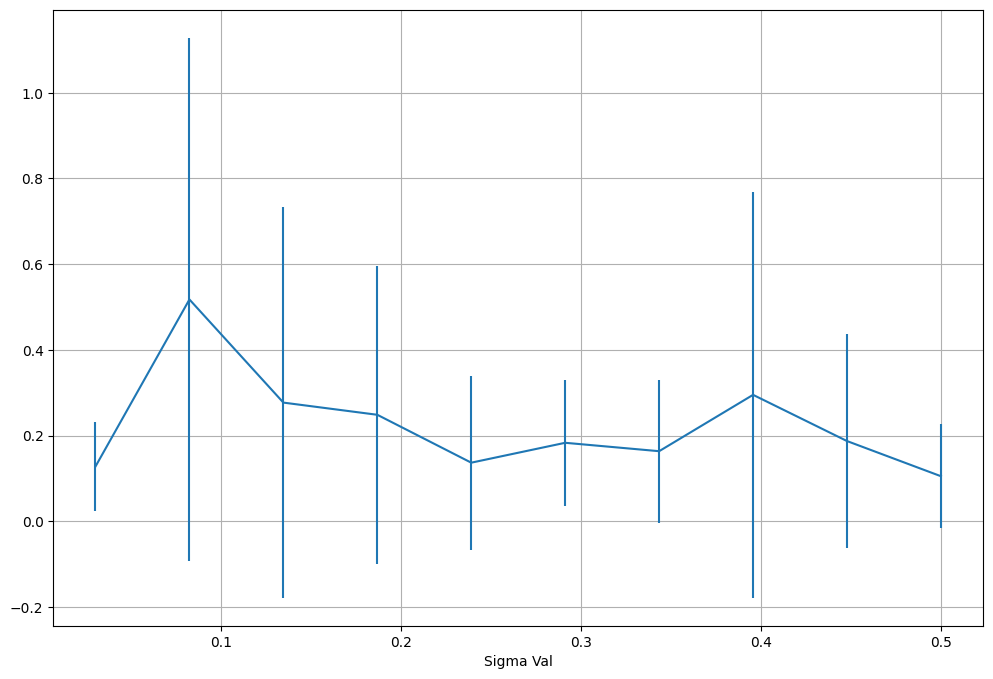

In [22]:
plt.figure(figsize=(12,8))
plt.errorbar(sigmas, loss_test_score.mean(1), yerr=loss_test_score.std(1))
plt.xlabel("Sigma Val")
plt.grid()

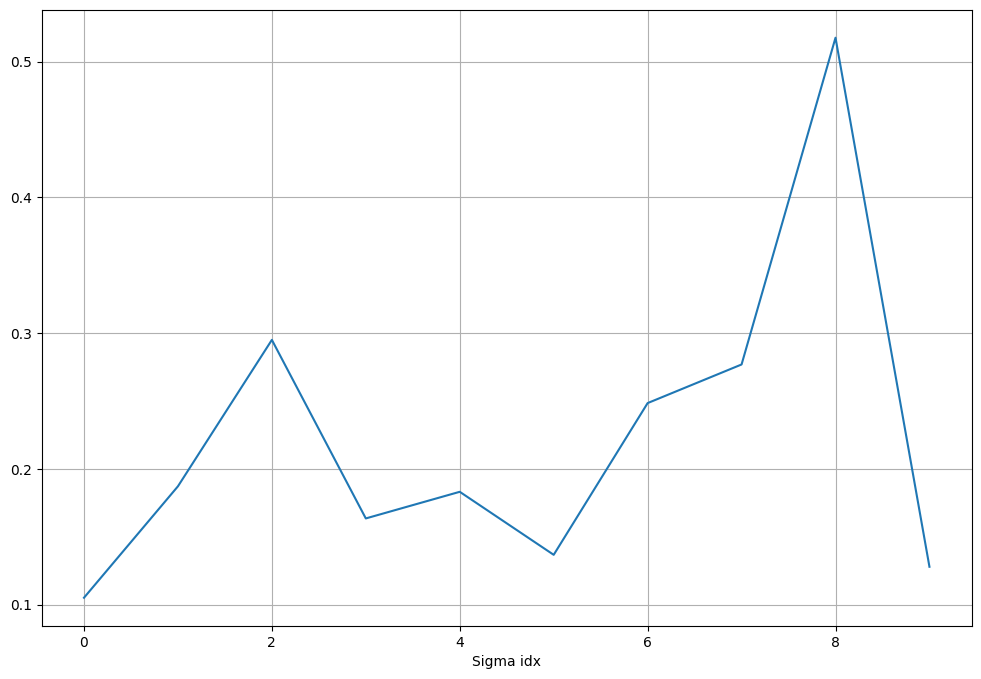

In [23]:
plt.figure(figsize=(12,8))
plt.errorbar(np.arange(len(sigmas)), loss_test_score.mean(1))#, yerr=loss_test_score.std(1))
plt.xlabel("Sigma idx")
plt.grid()

# Decreasing sigma

In [24]:
n_graphs = 15

loss_test_nodec_smallest = np.zeros(n_graphs)
loss_test_nodec_best = np.zeros(n_graphs)
loss_test_decreasing = np.zeros(n_graphs)
loss_test_sparsity_dec = np.zeros(n_graphs)

for g in range(n_graphs):
    print(f"{g+1} ", end="", flush=True)

    idx_g = np.random.randint(len(graphs))
    g_params['g'] = graphs[idx_g]

    X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

    X = torch.tensor(X).to(device).T[:,:,None].double()
    Y = torch.tensor(Y).to(device).T[:,:,None].double()
    S = torch.tensor(S).to(device).double()
    Sn = torch.tensor(Sn).to(device).double()

    idxs_y_split = torch.randperm(M)
    N_train = 0.7
    N_val = 0.15
    train_idx = idxs_y_split[:int(N_train*M)]
    val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
    test_idx = idxs_y_split[int((N_train+N_val)*M):]

    # With score function - no decreasing and using smallest
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=len(sigmas)-1, dec_sigma=False)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=0., omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_nodec_smallest[g] = results_dict['best_acc_test'].item()

    # With score function - no decreasing and using best sigma
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=best_sigma_idx, dec_sigma=False)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=0., omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_nodec_best[g] = results_dict['best_acc_test'].item()

    # With score function - decreasing
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=0, dec_sigma=True)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=0., omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_decreasing[g] = results_dict['best_acc_test'].item()

    # With sparsity term
    model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=sigma_i_idx)
    model.model = model.model.double().to(device)

    results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=beta, omega=0., train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
    loss_test_sparsity_dec[g] = results_dict['best_acc_test'].item()


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

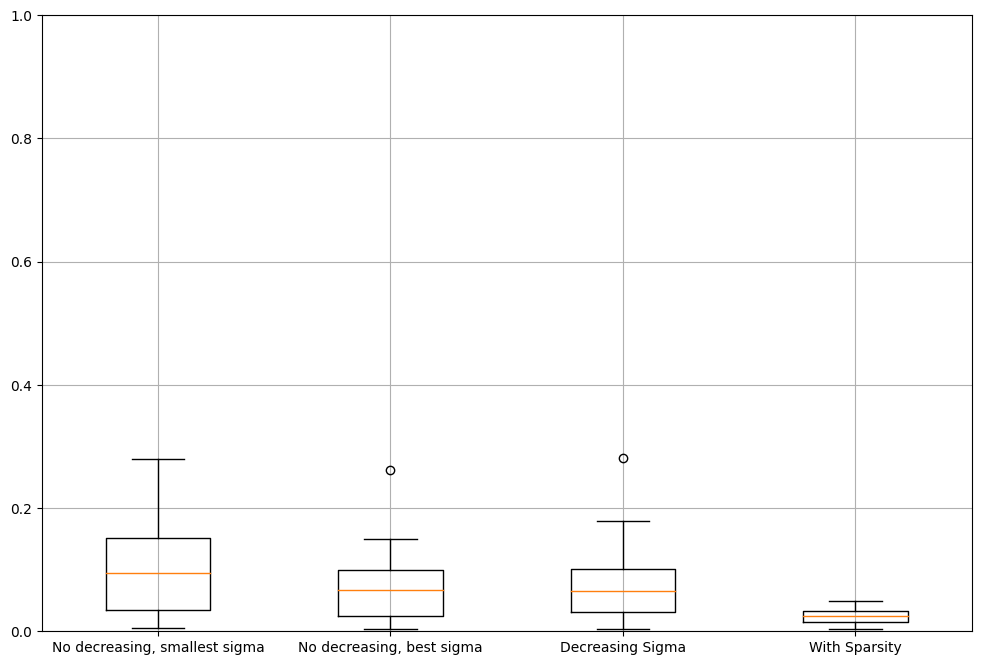

In [26]:
plt.figure(figsize=(12,8))
plt.boxplot([loss_test_nodec_smallest, loss_test_nodec_best, loss_test_decreasing, loss_test_sparsity_dec])
plt.xticks(np.arange(1,5), ["No decreasing, smallest sigma", "No decreasing, best sigma", "Decreasing Sigma", "With Sparsity"])
plt.ylim([0,1])
plt.grid()

# Hyperparameter omega tuning - decreasing sigma

In [27]:
n_graphs = 10

omegas = [0., 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1., 10.]

loss_test_score_hypomeg_dec = np.zeros((len(omegas), n_graphs))

for o, omega in enumerate(omegas):

    print(f"Starting with sigma value {omega} - {o+1} / {len(omegas)}")
    
    for g in range(n_graphs):
        print(f"{g+1} ", end="", flush=True)

        idx_g = np.random.randint(len(graphs))
        g_params['g'] = graphs[idx_g]

        X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

        X = torch.tensor(X).to(device).T[:,:,None].double()
        Y = torch.tensor(Y).to(device).T[:,:,None].double()
        S = torch.tensor(S).to(device).double()
        Sn = torch.tensor(Sn).to(device).double()

        idxs_y_split = torch.randperm(M)
        N_train = 0.7
        N_val = 0.15
        train_idx = idxs_y_split[:int(N_train*M)]
        val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
        test_idx = idxs_y_split[int((N_train+N_val)*M):]

        # With score function
        model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=0, dec_sigma=True)
        model.model = model.model.double().to(device)

        results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=0., omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
        loss_test_score_hypomeg_dec[o,g] = results_dict['best_acc_test'].item()
    print("- DONE")

Starting with sigma value 0.0 - 1 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.0001 - 2 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.001 - 3 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.01 - 4 / 9
1 2 

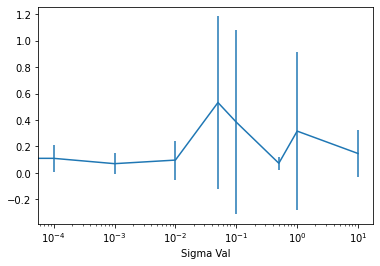

In [ ]:
plt.figure(figsize=(12,8))
plt.errorbar(omegas, loss_test_score_hypomeg_dec.mean(1), yerr=loss_test_score_hypomeg_dec.std(1))
plt.xlabel("Sigma Val")
plt.xscale('log')
plt.grid()

In [ ]:
best_omega_idx_dec = np.argmin(loss_test_score_hypomeg_dec.mean(1))
omegas[best_omega_idx_dec]

0.001

# Hyperparameter omega tuning - no decreasing sigma

In [ ]:
n_graphs = 10

loss_test_score_hypomeg_nodec = np.zeros((len(omegas), n_graphs))

for o, omega in enumerate(omegas):

    print(f"Starting with sigma value {omega} - {o+1} / {len(omegas)}")
    
    for g in range(n_graphs):
        print(f"{g+1} ", end="", flush=True)

        idx_g = np.random.randint(len(graphs))
        g_params['g'] = graphs[idx_g]

        X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

        X = torch.tensor(X).to(device).T[:,:,None].double()
        Y = torch.tensor(Y).to(device).T[:,:,None].double()
        S = torch.tensor(S).to(device).double()
        Sn = torch.tensor(Sn).to(device).double()

        idxs_y_split = torch.randperm(M)
        N_train = 0.7
        N_val = 0.15
        train_idx = idxs_y_split[:int(N_train*M)]
        val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
        test_idx = idxs_y_split[int((N_train+N_val)*M):]

        # With score function
        model = RobustGNNScore(Sn.clone(), n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="reg", loss_fn=nn.MSELoss, score_function=prior_score_estimator, sigmas=sigmas, sigma_i_idx=best_sigma_idx, dec_sigma=False)
        model.model = model.model.double().to(device)

        results_dict, S_dict = model.test_model(Sn.clone(), X, Y, gamma, lambd, beta=0., omega=omega, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, norm_S=False, S_true=S, es_patience=es_patience, verbose=False, debug_S=False)
        loss_test_score_hypomeg_nodec[o,g] = results_dict['best_acc_test'].item()
    print("- DONE")

Starting with sigma value 0.0 - 1 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.0001 - 2 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.001 - 3 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.01 - 4 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.05 - 5 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.1 - 6 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 0.5 - 7 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 1.0 - 8 / 9
1 2 3 4 5 6 7 8 9 10 - DONE
Starting with sigma value 10.0 - 9 / 9
1 2 3 4 5 6 7 8 9 10 - DONE


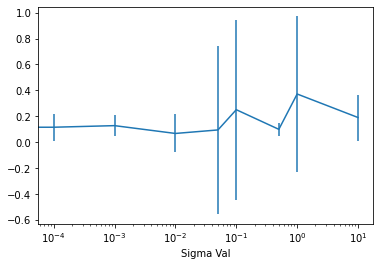

In [ ]:
plt.figure(figsize=(12,8))
plt.errorbar(omegas, loss_test_score_hypomeg_nodec.mean(1), yerr=loss_test_score_hypomeg_dec.std(1))
plt.xlabel("Sigma Val")
plt.xscale('log')
plt.grid()